# Causal Modelling with DoWhy and EconML

Useful links: 

https://github.com/py-why/EconML/blob/main/notebooks/CustomerScenarios/Case%20Study%20-%20Customer%20Segmentation%20at%20An%20Online%20Media%20Company%20-%20EconML%20%2B%20DoWhy.ipynb



# Imports

In [1]:
# Basic imports
import pandas as pd

# Visualization
from IPython.display import Image, display
import matplotlib.pyplot as plt

# Standard ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# EconML
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter

# Analysis
import shap

/Users/adi.jacobson/Developer/Github/causal-ice-cream/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [2]:
# Read in csv created during preprocessing

df = pd.read_csv('../data/causal_df.csv')
df.head()

,Unnamed: 0,date,day_of_week,weather_region_cd,maximum_feels_like_temperature,rainfall,sunshine_td,avg_ice_cream_price,ice_cream_sold,cpih,month
0,0,2022-03-27,0.0,1.0,15.4,0.2,12.1,2.704702,1498.0,6.2,3.0
1,1,2022-03-27,0.0,10.0,12.7,0.0,10.6,2.704702,2285.0,6.2,3.0
2,2,2022-03-27,0.0,11.0,15.1,0.0,10.2,2.704702,5509.0,6.2,3.0
3,3,2022-03-27,0.0,12.0,10.7,0.0,5.3,2.704702,7776.0,6.2,3.0
4,4,2022-03-27,0.0,13.0,13.1,0.0,8.6,2.704702,4903.0,6.2,3.0


In [3]:
df_grouped = df.groupby(['date']).agg({'maximum_feels_like_temperature':'mean', 'rainfall':'mean', 'sunshine_td':'mean', 'avg_ice_cream_price':'mean', 'ice_cream_sold':'sum', 'cpih':'mean', 'month':'mean', 'day_of_week':'mean'}).reset_index()

df_grouped.head()

,date,maximum_feels_like_temperature,rainfall,sunshine_td,avg_ice_cream_price,ice_cream_sold,cpih,month,day_of_week
0,2022-03-27,13.678571,0.014286,7.735714,2.704702,87104.0,6.2,3.0,0.0
1,2022-03-28,14.221429,0.671429,4.214286,2.704702,75953.0,6.2,3.0,1.0
2,2022-03-29,9.635714,0.814286,1.578571,2.704702,65999.0,6.2,3.0,2.0
3,2022-03-30,5.228571,1.657143,2.064286,2.704702,66168.0,6.2,3.0,3.0
4,2022-03-31,2.557143,1.128571,5.935714,2.704702,70270.0,6.2,3.0,4.0


# Creating Causal Graph

In [4]:
# Define estimator inputs

treatment = "maximum_feels_like_temperature"  # What do we want to find the effect of
outcome = "ice_cream_sold"  # Target
covariates = ["avg_ice_cream_price", "cpih", "rainfall", "sunshine_td", "month", "day_of_week"]  # Confounders to account for
# features = ["weather_region_cd", "day_of_week", "month"]  # Confounders to stratify on
features = []

X = df_grouped[covariates]
Y = df_grouped[outcome]
T = df_grouped[treatment]
# W = df_grouped[features]
W = None

In [5]:
# Y_train, Y_test, T_train, T_test, X_train, X_test, W_train, W_test = train_test_split(Y, T, X, W, test_size=.2)

Y_train, Y_test, T_train, T_test, X_train, X_test = train_test_split(Y, T, X, test_size=.2)

# Estimate Causal Effects

In [6]:
# Instansiate the causal model

est = CausalForestDML(
                        model_y=RandomForestRegressor(criterion='absolute_error')
                      , model_t=RandomForestRegressor(min_samples_leaf=10, criterion='absolute_error')
                      , discrete_treatment=False
                  )

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


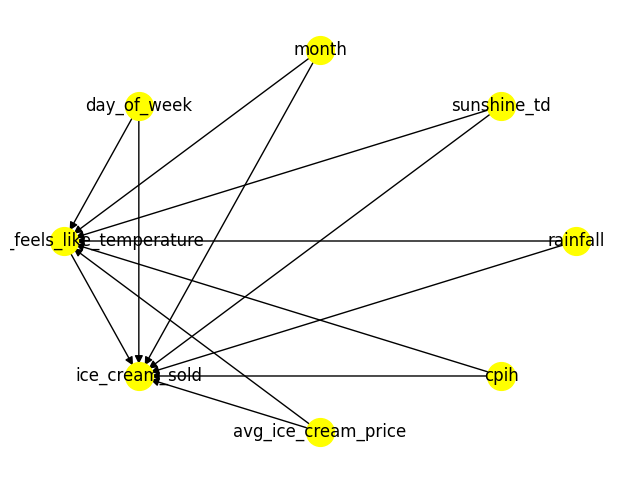

In [7]:
# fit through dowhy

%matplotlib inline

# est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=[outcome], treatment_names=[treatment], feature_names=covariates,
#               confounder_names=features, inference="auto")

est_dw = est.dowhy.fit(Y, T, X=X, W=None
                , outcome_names=[outcome]
                , treatment_names=[treatment]
                , feature_names=covariates
                , confounder_names=features
                , inference="auto"
                , control_value = 15
                , treatment_value = 25)

est_dw.view_model() 

In [8]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                             
─────────────────────────────────(E[ice_cream_sold|day_of_week,cpih,rainfall,s
d[maximum_feels_like_temperature]                                             

                                     
unshine_⟨td,month,⟩_ice_cream_price])
                                     
Estimand assumption 1, Unconfoundedness: If U→{maximum_feels_like_temperature} and U→ice_cream_sold then P(ice_cream_sold|maximum_feels_like_temperature,day_of_week,cpih,rainfall,sunshine_td,month,avg_ice_cream_price,U) = P(ice_cream_sold|maximum_feels_like_temperature,day_of_week,cpih,rainfall,sunshine_td,month,avg_ice_cream_price)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
print(est_dw.estimate_)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                             
─────────────────────────────────(E[ice_cream_sold|day_of_week,cpih,rainfall,s
d[maximum_feels_like_temperature]                                             

                                     
unshine_⟨td,month,⟩_ice_cream_price])
                                     
Estimand assumption 1, Unconfoundedness: If U→{maximum_feels_like_temperature} and U→ice_cream_sold then P(ice_cream_sold|maximum_feels_like_temperature,day_of_week,cpih,rainfall,sunshine_td,month,avg_ice_cream_price,U) = P(ice_cream_sold|maximum_feels_like_temperature,day_of_week,cpih,rainfall,sunshine_td,month,avg_ice_cream_price)

## Realized estimand
b: ice_cream_sold~maximum_feels_like_temperature+day_of_week+cpih+rainfall+sunshine_td+month+avg_ice_cream_price | avg_ice_cream_price,cpih,rainfal

In [10]:
# Interpret the estimate

est_dw.estimate_.interpret()

Increasing the treatment variable(s) [maximum_feels_like_temperature] from [15] to [25] causes an increase of 33864.23470496934 in the expected value of the outcome [ice_cream_sold], over the data distribution/population represented by the dataset.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


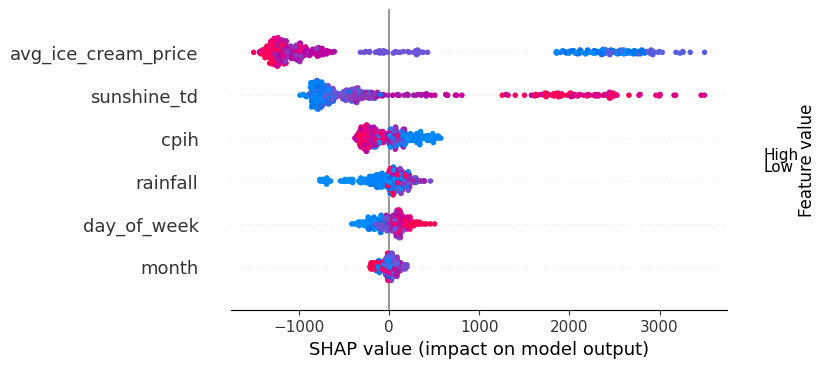

In [11]:
shap_values = est_dw.shap_values(X)
shap.plots.beeswarm(shap_values['ice_cream_sold']['maximum_feels_like_temperature'])

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


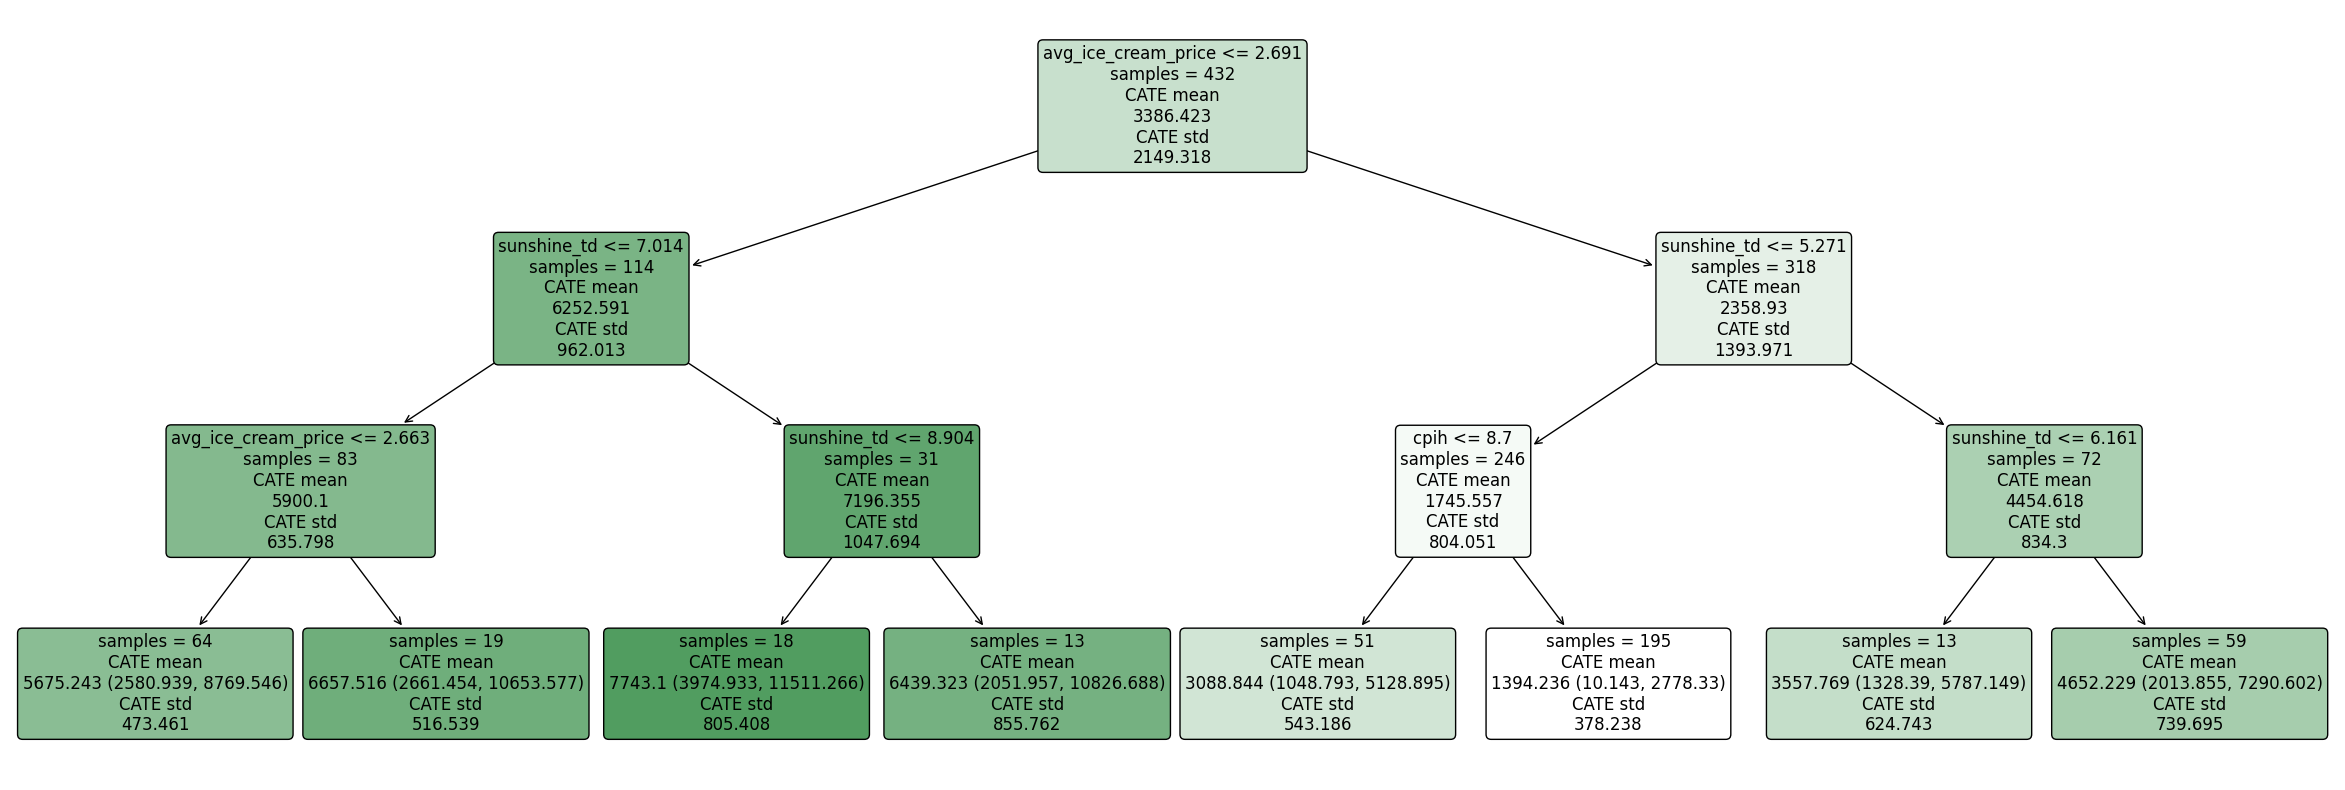

In [12]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3).interpret(est_dw, X)

plt.figure(figsize=(30,10))
intrp.plot(feature_names=X.columns, fontsize=12)

# Refutes!

Add Random Common Cause
How robust are our estimates to adding another confounder? We use DoWhy to test this!

In [13]:
res_random = est_dw.refute_estimate(method_name="random_common_cause", num_simulations=5)
print(res_random)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Refute: Add a random common cause
Estimated effect:33864.23470496934
New effect:37397.65379303388
p value:0.19837221273192457



Add Unobserved Common Cause
How robust are our estimates to unobserved confounders? Since we assume the model is under unconfoundedness, adding an unobserved confounder might bias the estimates. We use DoWhy to test this!

In [14]:
res_unobserved = est_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Refute: Add an Unobserved Common Cause
Estimated effect:33864.23470496934
New effect:32162.594379622653



Replace Treatment with a Random (Placebo) Variable
What happens our estimates if we replace the treatment variable with noise? Ideally, the average effect would be wildly different than our original estimate. We use DoWhy to investigate!

In [15]:
res_placebo = est_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Refute: Use a Placebo Treatment
Estimated effect:33864.23470496934
New effect:1676.5899897112113
p value:0.20673218502675195



Remove a Random Subset of the Data
Do we recover similar estimates on subsets of the data? This speaks to the ability of our chosen estimator to generalize well. We use DoWhy to investigate this!

In [16]:
res_subset = est_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Refute: Use a subset of data
Estimated effect:33864.23470496934
New effect:32981.633812650645
p value:0.3010103341833641

